# PCA, mnist
### Борунов Семён Сергеевич НММбд-01-22

In [1]:
from mnist import load_mnist

In [2]:
train, validation, test = load_mnist()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [3]:
from matplotlib import pyplot as plt
import sklearn
import numpy as np
from sklearn.metrics import accuracy_score


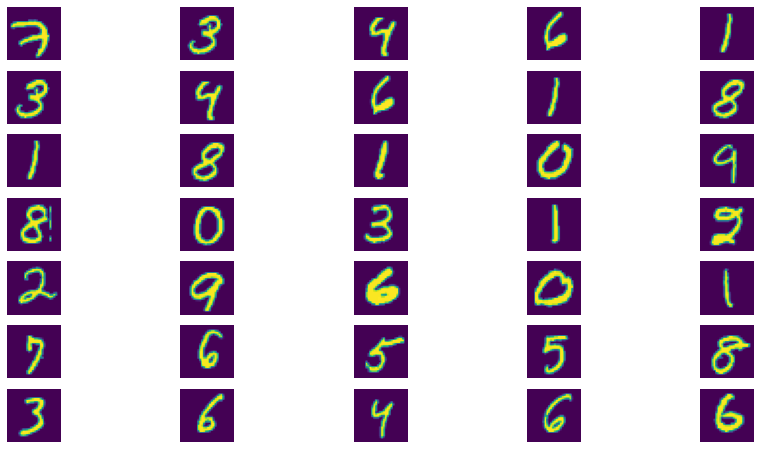

In [4]:
fig, ax = plt.subplots(7, 5, figsize=(15, 8))
for i in range(7):
    for j in range(5):
        ax[i][j].imshow(train[0][i**2 + j])
        ax[i][j].axis('off')

In [5]:
len(train)

2

In [8]:
class my_PCA():
    def __init__(self, n_components=2):
        self.n_components = n_components
    
    
    def fit(self, X):
        self.X_mean = X.mean(axis=0)
        X_centred = (X - self.X_mean)
        Cov = X_centred.T @ X_centred
        self.evals, self.F = np.linalg.eig(Cov)

        self.princ_comp = self.F[:, :self.n_components]
        
        return self        
    
    
    def transform(self, X):
        X_centred = (X - self.X_mean)
        
        return X_centred @ self.princ_comp
        
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    
    def draw_cool_graphs(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        ax[0].set_title("eigen values")
        ax[0].set_xlabel('principal component num')
        ax[0].set_ylabel('value')
        ax[0].scatter(range(len(self.evals)), self.evals)
        
        cum_sum = np.cumsum(self.evals / np.sum(self.evals) * 100)
        ax[1].set_title("cummulative sums")
        ax[1].set_xlabel('principal component quantity')
        ax[1].set_ylabel('% of explonation')
        ax[1].plot(range(len(cum_sum)), cum_sum)
        print(f'когда мы берем {self.n_components} компоненты мы сохраняем {cum_sum[self.n_components - 1]}% информации')

        
    

In [9]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.all_calsses = set(y)
    
    
    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_neighbors]
            unique, counts = np.unique(nearest_labels, return_counts=True)
            y_pred.append(unique[np.argmax(counts)])
        return np.array(y_pred)

В целом данные уже разбиты на выборки, так что отдельно сплитить их не надо

Сделаем из наших картинок обычные плоские вектора

In [6]:
X, labels = train[0], train[1]
X.shape, labels.shape

((55000, 28, 28, 1), (55000,))

In [7]:
X = X.reshape(55000, -1)

In [10]:
X_test, y_test = validation[0], validation[1]
X_test = X_test.reshape(5000, -1)

Посмотрим на какие-нибудь срезы наших данных, может на них что-то видно?

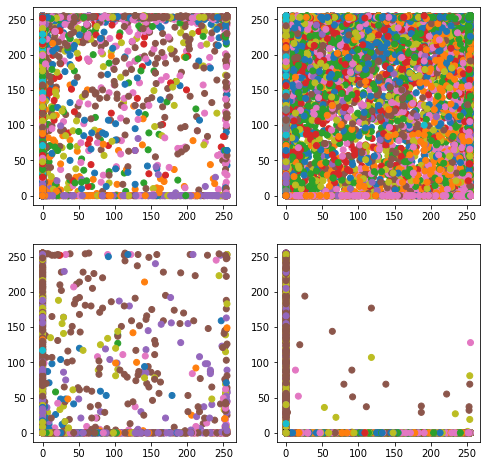

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        ax[i][j].scatter(X[:, 134 + i**2  - 5*j ], X[:, 185 + j**2 + 7*i], cmap='tab10', c=labels)


Нет, не ясно вообще ничего. В каких-то срезах точки разбросаны равномерно, где-то сбиты на края, на 4 картинке кажется что вообще точек мало.  
Теперь визуализируем только проекции на 2 главные компоненты

In [11]:
data_zipper = my_PCA(n_components=2)
data_zipper.fit(X)
X_zip = data_zipper.transform(X)

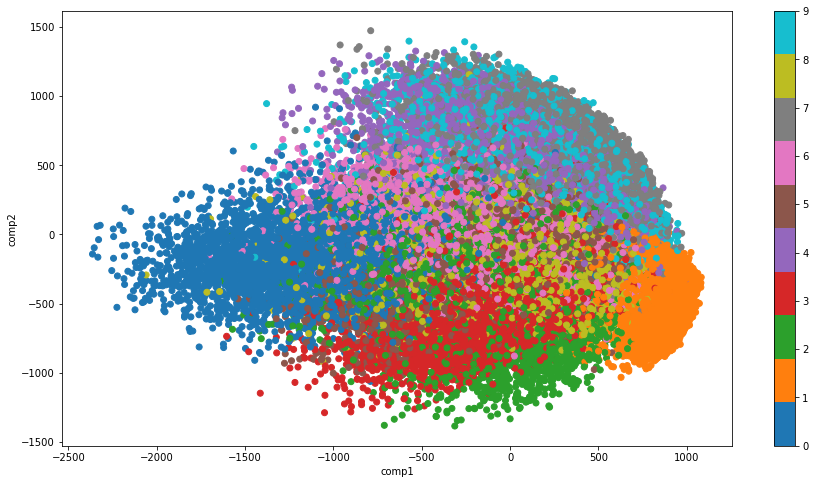

In [12]:
plt.figure(figsize=(15, 8))
plt.xlabel('comp1')
plt.ylabel('comp2')

plt.scatter(X_zip[:, 0], X_zip[:, 1], cmap='tab10', c=labels)
plt.colorbar()


На этом графике уже видны кластеры некоторых чисел. Например 0 и 1 вообще обособлены, 2 с 3 тоже вполне разичимы и кажется эти значения вполне можно отделять линейными моделями.  
  
  Посмотрим теперь какую часть информации мы сохранили, оставив только 2 компонеты

когда мы берем 2 компоненты мы сохраняем 16.76929561326255% информации


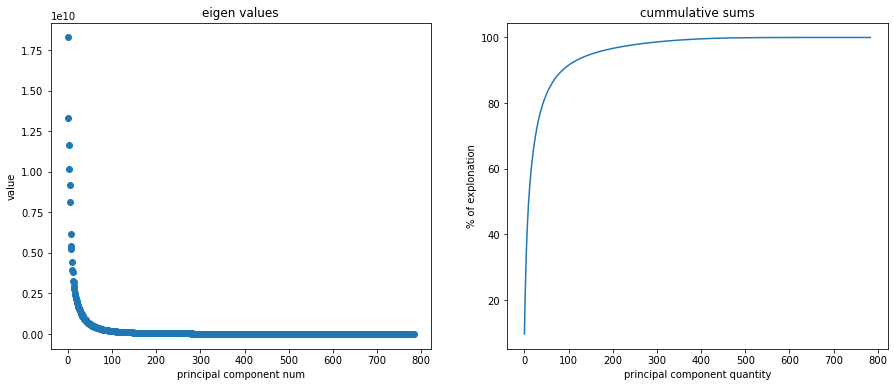

In [13]:
data_zipper.draw_cool_graphs()

In [14]:
model = my_kNN(n_neighbors=5)
model.fit(X_zip, labels)
y_pred = model.predict(data_zipper.transform(X_test))

print(f'Точность алгоритма: {accuracy_score(y_test, y_pred)}')

Точность алгоритма: 0.4186


На 2 компонентах точность в почти 50% кажется не таким уж и плохим результатом 
  
  Поотимизируем теперь наши значения количества соседей и главынх компонент

In [ ]:
best_accuracy = 0
best_neighbors = 0
best_components = 0
for n_neighbors in range(1, 11):
    for n_components in range(1, 31):
        model = my_kNN(n_neighbors=n_neighbors)
        zipper = my_PCA(n_components=n_components)
        
        model.fit(zipper.fit_transform(X), labels)
        y_pred = model.predict(zipper.transform(X_test))
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_neighbors = n_neighbors
            best_components = n_components

In [ ]:
print(f'наилучшая точность: {best_accuracy}\nс количеством соседей: {best_neighbors}\nи компонент: {best_components}')

К сожалению мой ноутбук не тянет сложные вычисления, поэтому я ограничусь более скудным набором соседей и компонент :(